# Combining Site-Specific Prediction and Exon-Level Prediction

Okay, let's try to combine algorithms that spit out one value for the whole exon and algorithms that give the predicted PSI at each point.

But first, let's try the sum-max model...

In [1]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

Using Theano backend.


In [4]:
num_filters = [100,64,32]
filter_length = [10,6,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(keras_pooling.SumMaxPool())
model1.add(Flatten())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [5]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [6]:
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [7]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 1519s - loss: 0.5983 - acc: 1.0000 - val_loss: 0.5618 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 1494s - loss: 0.5624 - acc: 1.0000 - val_loss: 0.5557 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 3618s - loss: 0.5514 - acc: 1.0000 - val_loss: 0.5401 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 1643s - loss: 0.5460 - acc: 1.0000 - val_loss: 0.5421 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 1607s - loss: 0.5429 - acc: 1.0000 - val_loss: 0.5350 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 1698s - loss: 0.5403 - acc: 1.0000 - val_loss: 0.5523 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 1767s - loss: 0.5383 - acc: 1.0000 - val_loss: 0.5308 - val_acc: 1.0000
Epoch 8/50
212035/212035 

In [8]:
table1 = pd.read_table('../data/mmc2.tsv')
wt_seqs = table1.WT_SEQ
mut_seqs = table1.MUT_SEQ
wt_seqs_encoded = [nn_utils.seq_to_array(x) for x in wt_seqs]
mut_seqs_encoded = [nn_utils.seq_to_array(x) for x in mut_seqs]
wt_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), wt_seqs_encoded)
mut_seqs_encoded = map(lambda x: x.reshape((1, x.shape[0], x.shape[1])), mut_seqs_encoded)

In [9]:
from keras import backend as K

expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [10]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [11]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]

In [12]:
hal_pred = []
model_pred = []
for h, m in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred):
    if h!=None and h>=-1 and h<=1:
        hal_pred.append(h)
        model_pred.append(m)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


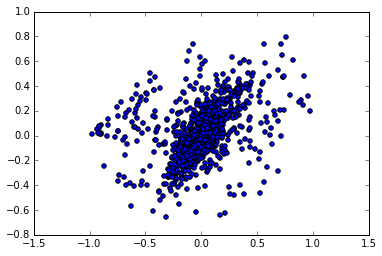

In [13]:
plt.scatter(hal_pred, model_pred)

In [32]:
hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

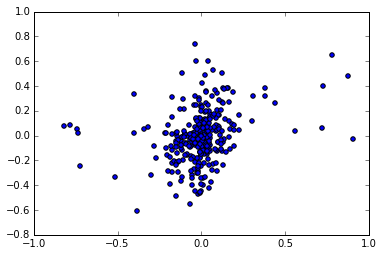

In [15]:
plt.scatter(actual, model_pred_2)

In [16]:
r2_score(hal_pred, model_pred)

-0.0049246502487394483

In [19]:
import statsmodels.api as sm

In [20]:
reg = sm.OLS?

In [36]:
reg = sm.OLS(model_pred_2, actual)

In [37]:
f = reg.fit()

In [54]:
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     50.99
Date:                Thu, 17 Mar 2016   Prob (F-statistic):           4.14e-12
Time:                        13:16:23   Log-Likelihood:                 101.83
No. Observations:                 419   AIC:                            -201.7
Df Residuals:                     418   BIC:                            -197.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4145      0.058      7.141      0.000         0.300     0.529
==============================================================================
Omnibus:                       26.526   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.335
Skew:                           0.120   Prob(JB):                     1.79e-19
Kurtosis:                       5.211   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
model1.save_weights('../data/convolutional-sum-max.h5')
model_json = model1.to_json()
with open('../data/convolutional-sum-max-model.json', 'w') as f:
    f.write(model_json)

In [40]:
model2 = model_from_json(open('../data/convolutional-sum-model.json').read(), custom_objects={'SumLayer': keras_pooling.SumLayer})

In [47]:
model2.load_weights('../data/convolutional-sum.h5')
expit = lambda x: 1./(1.+np.exp(-x))
logit = lambda x: np.log(x)-np.log(1-x)

get_3rd_layer_output_1 = K.function([model2.layers[0].input],
                                  [model2.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [48]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [49]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

In [50]:
reg = sm.OLS(model_pred_2, actual)

In [51]:
f = reg.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     50.99
Date:                Thu, 17 Mar 2016   Prob (F-statistic):           4.14e-12
Time:                        10:43:42   Log-Likelihood:                 101.83
No. Observations:                 419   AIC:                            -201.7
Df Residuals:                     418   BIC:                            -197.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.4145      0.058      7.141      0.000         0.300     0.529
==============================================================================
Omnibus:                       26.526   Durbin-Watson:                   1.585
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.335
Skew:                           0.120   Prob(JB):                     1.79e-19
Kurtosis:                       5.211   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

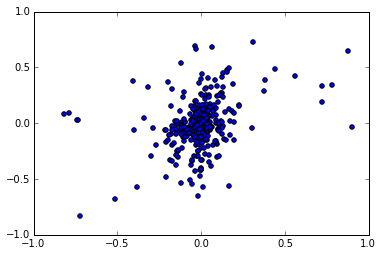

In [52]:
plt.scatter(actual, model_pred_2)

In [53]:
model3 = model_from_json(open('../data/splice-site-recurrent-2-model.json').read())

In [55]:
model3.load_weights('../data/splice-site-recurrent-2.h5')

In [59]:
get_3rd_layer_output_3 = K.function([model3.layers[0].input],
                                  [model3.layers[-2].get_output(train=False)])
get_output_3 = K.function([model3.layers[0].input],
                                  [model3.layers[-1].get_output(train=False)])

In [73]:
result0 = get_output_3([wt_seqs_encoded[0]])[0].flatten()

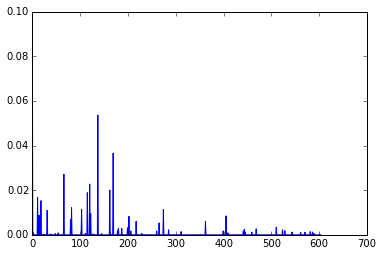

In [74]:
plt.plot(result0)
plt.show()

In [71]:
result = get_output_3([mut_seqs_encoded[0]])[0].flatten()

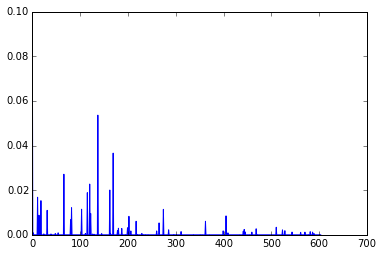

In [72]:
plt.plot(result)
plt.show()

In [76]:
sum(result - result0)

1.3935650713392533e-06

In [77]:
model_pred[0]

-0.0071880184

In [78]:
hal_pred[0]

-0.013803373999999998

## New Model: single convolutional layer, sum pooling

since max pooling seems to make things worse...

In [82]:
num_filters = [300,64,32]
filter_length = [6,6,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
#model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(keras_pooling.SumLayer())
model1.add(Flatten())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [83]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [84]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 311s - loss: 0.6020 - acc: 1.0000 - val_loss: 0.5790 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 318s - loss: 0.5746 - acc: 1.0000 - val_loss: 0.5670 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 308s - loss: 0.5685 - acc: 1.0000 - val_loss: 0.5749 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 310s - loss: 0.5658 - acc: 1.0000 - val_loss: 0.5656 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 311s - loss: 0.5635 - acc: 1.0000 - val_loss: 0.5616 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 297s - loss: 0.5623 - acc: 1.0000 - val_loss: 0.5544 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 296s - loss: 0.5604 - acc: 1.0000 - val_loss: 0.5556 - val_acc: 1.0000
Epoch 8/50
212035/212035 [======

In [86]:
get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [87]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [88]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

In [89]:
reg = sm.OLS(model_pred_2, actual)
f = reg.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     31.71
Date:                Thu, 17 Mar 2016   Prob (F-statistic):           3.30e-08
Time:                        16:09:01   Log-Likelihood:                 274.12
No. Observations:                 419   AIC:                            -546.2
Df Residuals:                     418   BIC:                            -542.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2167      0.038      5.631      0.000         0.141     0.292
==============================================================================
Omnibus:                       40.677   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              219.506
Skew:                           0.058   Prob(JB):                     2.16e-48
Kurtosis:                       6.544   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
plt.scatter(actual, model_pred_2)

Okay so this sucks.

let's go deeper.

In [92]:
num_filters = [200,100,32]
filter_length = [6,6,6]

model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_dim=4))
model1.add(Dropout(0.25))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(keras_pooling.SumLayer())
model1.add(Flatten())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))

In [93]:
model1.compile(loss='binary_crossentropy',
              optimizer='adam')

In [94]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 5518s - loss: 0.6092 - acc: 1.0000 - val_loss: 0.5755 - val_acc: 1.0000
Epoch 2/50
212035/212035 [==============================] - 5588s - loss: 0.5698 - acc: 1.0000 - val_loss: 0.5598 - val_acc: 1.0000
Epoch 3/50
212035/212035 [==============================] - 5365s - loss: 0.5601 - acc: 1.0000 - val_loss: 0.5549 - val_acc: 1.0000
Epoch 4/50
212035/212035 [==============================] - 5341s - loss: 0.5567 - acc: 1.0000 - val_loss: 0.5518 - val_acc: 1.0000
Epoch 5/50
212035/212035 [==============================] - 5343s - loss: 0.5538 - acc: 1.0000 - val_loss: 0.5467 - val_acc: 1.0000
Epoch 6/50
212035/212035 [==============================] - 5344s - loss: 0.5525 - acc: 1.0000 - val_loss: 0.5455 - val_acc: 1.0000
Epoch 7/50
212035/212035 [==============================] - 5336s - loss: 0.5511 - acc: 1.0000 - val_loss: 0.5489 - val_acc: 1.0000
Epoch 8/50
212035/212035 

In [95]:
model1.save_weights('../data/convolutional-sum-2.h5')
model_json = model1.to_json()
with open('../data/convolutional-sum-2-model.json', 'w') as f:
    f.write(model_json)

In [96]:
get_3rd_layer_output_1 = K.function([model1.layers[0].input],
                                  [model1.layers[-2].get_output(train=False)])
def get_score(input_data):
    return get_3rd_layer_output_1([input_data])[0]
    #return (get_3rd_layer_output_2([input_data])[0] + get_3rd_layer_output_1([input_data])[0])/2

def get_delta_psi(wt_seq, mut_seq, wt_psi):
    score_wt = get_score(wt_seq)
    score_mut = get_score(mut_seq)
    mut_psi = expit(score_mut - score_wt + logit(wt_psi))
    return mut_psi - wt_psi

In [97]:
nn_delta_psi = [get_delta_psi(w, m, p) for w, m, p in tqdm.tqdm(zip(wt_seqs_encoded, mut_seqs_encoded, table1.WT_PSI))]

In [98]:
model_dpsi_pred = [x[0][0] for x in nn_delta_psi]
hal_pred_2 = []
model_pred_2 = []
actual = []
pos_or_neg = []
for h, m, a in zip(table1.HOMO_DPSI_PRED, model_dpsi_pred, table1.HOMO_DPSI):
    if h!=None and h>=-1 and h<=1 and a>=-1 and a<=1:
        hal_pred_2.append(h)
        model_pred_2.append(m)
        actual.append(a)
        if h>=0 and m>=0:
            pos_or_neg.append(1)
        elif h<=0 and m<=0:
            pos_or_neg.append(0)

In [99]:
reg = sm.OLS(model_pred_2, actual)
f = reg.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     48.15
Date:                Sat, 19 Mar 2016   Prob (F-statistic):           1.51e-11
Time:                        22:34:06   Log-Likelihood:                 154.01
No. Observations:                 419   AIC:                            -306.0
Df Residuals:                     418   BIC:                            -302.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.3556      0.051      6.939      0.000         0.255     0.456
==============================================================================
Omnibus:                       40.080   Durbin-Watson:                   1.584
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.581
Skew:                           0.075   Prob(JB):                     1.87e-46
Kurtosis:                       6.470   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [100]:
plt.scatter(actual, model_pred_2)